In [1]:
import numpy as np
import autograd.numpy as anp

# Model parameters
γ = 10.
ρ = 2./3

χ = 0.9
α = 0.9
ϵ = 10.

a = .00663 # risk free growth rate of capital
g = .00373 # deterministic growth trend of income
A = np.array([[.704, 0, 0],[0, 1, -.154],[0,1,0]])
B = np.array([[0.144,0],[0,0.206],[0,0]])

internal = True #True: internal habit; False: external habit.

KoverY_ss = 0.

args = (γ, ρ, χ, α, ϵ, a, g, A, B, internal, KoverY_ss)

'''
f=[f1,f2] which satisfy E[Mf1] = 0 and f2=0.

'''
def eq_cond(X_t, X_tp1, W_tp1, q, *args):
    # Parameters for the model
    γ, ρ, χ, α, ϵ, a, g, A, B, internal, _ = args

    # Variables:
    # log V_t/Y_t, log R_t/Y_t, log U_t/Y_t, log C_t/Y_t,log MH_t/MU_t, log MC_t/MU_t, I_t/Y_t - JUMP VARIABLES
    # log H_t/Y_t, K_t/Y_t, log(Y_t/Y_{t-1}), Z_{1,t}, Z_{2,t}, Z_{2,t-1} - STATE VARIABLES
    if internal:
        vmy_t, rmy_t, umy_t, cmy_t, mhmu_t,mcmu_t, IoverY_t, \
            hmy_t, KoverY_t, gy_t, z1_t, z2_t, z2l_t= X_t.ravel()
        vmy_tp1, rmy_tp1, umy_tp1, cmy_tp1, mhmu_tp1, mcmu_tp1, IoverY_tp1, \
            hmy_tp1, KoverY_tp1, gy_tp1, z1_tp1, z2_tp1, z2l_tp1= X_tp1.ravel()
    else:
        vmy_t, rmy_t, umy_t, cmy_t, mcmu_t, IoverY_t, \
            hmy_t, KoverY_t, gy_t, z1_t, z2_t, z2l_t= X_t.ravel()
        vmy_tp1, rmy_tp1, umy_tp1, cmy_tp1, mcmu_tp1, IoverY_tp1, \
            hmy_tp1, KoverY_tp1, gy_tp1, z1_tp1, z2_tp1, z2l_tp1= X_tp1.ravel()

    # Exogenous states (stacked together)
    Z_t = anp.array([z1_t, z2_t, z2l_t])
    Z_tp1 = anp.array([z1_tp1, z2_tp1, z2l_tp1])

    # log SDF in units of U, EXCLUDING the change of measure term
    β = anp.exp(g * ρ - anp.log(1 + a))
    sdf_u = anp.log(β) + (ρ - 1) * (vmy_tp1 + gy_tp1 - rmy_t) - ρ * (umy_tp1 + gy_tp1 - umy_t)
    sdf_ex = sdf_u + mcmu_tp1 - mcmu_t

    # Eq0: Change of measure evaluated at γ=0. --- (2) in Section 1
    # THIS CHANGE OF MEASURE EQUATION MUST BE THE FIRST EQUATION. Order of others doesn't matter.
    m = vmy_tp1 + gy_tp1 - rmy_t
    # Eq1: Recursive utility --- (1) in Section 1
    if ρ == 1.:
        res_1 = anp.exp((1-β)*umy_t) * anp.exp(β*rmy_t) - anp.exp(vmy_t)
    else:
        res_1 = (1-β)*anp.exp((1-ρ)*(umy_t)) + β*anp.exp((1-ρ)*(rmy_t)) - anp.exp((1-ρ)*(vmy_t))
    # Eq2: Utility function --- (3) in Section 1
    if ϵ == 1.:
        res_2 = anp.exp((1-α)*cmy_t) * anp.exp(α*hmy_t) - anp.exp(umy_t)
    else:
        res_2 = anp.log((1-α)*anp.exp((1-ϵ)*cmy_t)+α*anp.exp((1-ϵ)*hmy_t))/(1-ϵ) - (umy_t)
    # Eq3: FOC on investment --- (9) in Section 1
    res_3 = anp.log(1+a) + sdf_ex
    if internal:
        # Eq4: MC/MU --- (8-a) in Section 1
        res_4 = (1-α)*anp.exp(ϵ*(umy_t-cmy_t)) + (1-χ)*anp.exp(sdf_u+mhmu_tp1) - anp.exp(mcmu_t)
        # Eq5: MH/MU --- (8-b) in Section 1
        res_5 = α*anp.exp(ϵ*(umy_t-hmy_t)) + χ*anp.exp(sdf_u+mhmu_tp1) - anp.exp(mhmu_t)
    else:
        # Eq4: MC/MU --- (8) in Section 1. No MH/MU when external.
        res_4 = (1-α)*anp.exp(ϵ*(umy_t-cmy_t)) - anp.exp(mcmu_t)
    # Eq6: Capital growth --- (5-b) in Section 1
    res_6 = KoverY_tp1 * anp.exp(gy_tp1) + anp.exp(cmy_t) - ((1+a)*KoverY_t + 1)
    # Eq7: Habit evolution --- (4) in Section 1
    res_7 = anp.exp(hmy_tp1+gy_tp1) - χ*anp.exp(hmy_t) - (1-χ)*anp.exp(cmy_t)
    # Eq8: Nonfinancial income process --- (6) in Section 1
    res_8 = gy_tp1 - .01 * (z1_tp1 + z2_tp1 - z2_t) - g
    # Eq9-11: State process  --- (7) in Section 1
    res_9 = (A@Z_t + B@W_tp1 - Z_tp1)[0]
    res_10 = (A@Z_t + B@W_tp1 - Z_tp1)[1]
    res_11 = (A@Z_t + B@W_tp1 - Z_tp1)[2]
    
    res_12 = KoverY_tp1 * anp.exp(gy_tp1) - KoverY_t - IoverY_t
    
    if internal:
        return anp.array([m, res_1,res_2,res_3,res_4,res_5,res_6,res_7,res_12, res_8,res_9, res_10, res_11])
    else:
        return anp.array([m, res_1,res_2,res_3,res_4,res_6,res_7,res_12, res_8,res_9, res_10, res_11])

In [2]:
def ss_func(*args):

    '''
    User-defined function to calculate steady states.

    Alternatively, users can simply provide a hard-coded np.array for steady states.

    '''
    
    # Extra parameters for the model
    γ, ρ, χ, α, ϵ, a, g, A, B, internal, KoverY_ss = args
    
    KoverY = KoverY_ss # This is a condition that we can freely impose
    β = np.exp(g * ρ - np.log(1+a)) # From FOC (9)
    gy = g # From (6). This is just the deterministic growth trend of income

    # Starting from the steady state of Y_{t+1}/Y_{t} and K/Y,
    # we can solve the steady state of other variables by hand:
    cmy = np.log(((1+a) - np.exp(g)) * KoverY + 1) # From (5-b)
    hmy = np.log(1-χ) + cmy - np.log((np.exp(g) - χ)) # From (4)
    if ϵ == 1.:
        umy = (1-α)*cmy + α*hmy # From (3) special case
    else:
        umy = np.log((1-α)*np.exp((1-ϵ)*cmy) + α * np.exp((1-ϵ)*hmy)) / (1-ϵ) # From (3)

    λ = β * np.exp((1-ρ)*g)
    
    if ρ == 1.:
        vmy = (1-β)*umy + β*rmy # From (1) special case
    else:
        vmy = (np.log((1-β)*np.exp((1-ρ)*umy)) - np.log(1-λ)) / (1-ρ) # From (1)
    rmy = vmy + gy # From (2)
    
    IoverY = KoverY*(np.exp(gy)-1)
    
    # steady state of Z components (=0, by stationarity of the two AR process)
    z1 = 0.
    z2 = 0.
    z2l = 0.
    
    if internal:
        mhmu = np.log(α) + ϵ * (umy - hmy) - np.log(1 - χ * β * np.exp(-g * ρ)) # From (8'-b)
        mcmu = np.log((1-α) * np.exp(ϵ * (umy - cmy)) + (1 - χ) * β * np.exp(-g * ρ) * np.exp(mhmu)) # From (8'-a)
        X_0 = np.array([vmy, rmy, umy, cmy, mhmu, mcmu, IoverY, hmy, KoverY, gy, z1, z2, z2l])
        
    else:
        mcmu = np.log((1-α) * np.exp(ϵ * (umy - cmy))) # From (8)
        X_0 = np.array([vmy, rmy, umy, cmy, mcmu, IoverY, hmy, KoverY, gy, z1, z2, z2l])
        
    return X_0

In [3]:
from expansion import recursive_expansion

if internal:
    var_shape = (7,6,2) # (number of controls, number of states, number of shocks)
else:
    var_shape = (6,6,2)

modelSol = recursive_expansion(eq_cond=eq_cond,
                               ss=ss_func,
                               var_shape=var_shape, 
                               γ=args[0],
                               second_order=False,# False: only 1st order expansion; True: include 2nd order expansion
                               args=args)

/home/hohanson/.local/lib/python3.8/site-packages/autograd/tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [4]:
np.set_printoptions(precision=6,suppress=True)
modelSol.X1_tp1.coeffs # First order LOM coefficients

{'c': array([[-0.034644],
        [-0.034744],
        [ 0.      ],
        [ 0.      ],
        [ 0.000184],
        [ 0.000191],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ],
        [ 0.      ]]),
 'x': array([[ 0.022513,  0.002828,  0.      ,  0.015984, -0.009595,  0.001512],
        [ 0.020151,  0.002835,  0.      ,  0.01604 , -0.009618,  0.001512],
        [ 0.841974,  0.000457,  0.      , -0.003318, -0.001551,  0.001536],
        [ 0.064614,  0.002706,  0.      ,  0.014992, -0.009182,  0.001514],
        [-0.09187 ,  0.000266,  0.      ,  0.002164, -0.000902, -0.000003],
        [ 0.562755, -0.001628,  0.      , -0.013255,  0.005524,  0.000016],
        [-0.065087,  0.003925,  0.      , -0.015137,  0.009242, -0.001513],
        [ 0.904058,  0.000278,  0.      , -0.00478 , -0.000942,  0.001537],
        [-0.071416,  1.000207,  0.      , -0.021785,  0.009078,  0.000026],
        [ 0.      ,  0.      , 

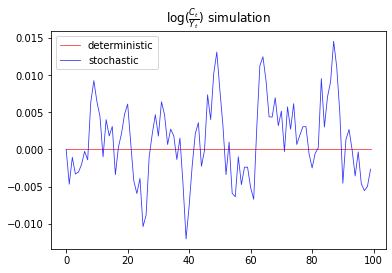

In [5]:
T = 100 # time horizon for simulation
_, _, n_W = modelSol.var_shape # the number of shocks within this model
Ws_1 = np.zeros((T,n_W)) # "generate" zero shocks throughout the horizon T=100
sim_result_1 = modelSol.simulate(Ws_1) # feed the generated shocks to the simulate method

Ws_2 = np.random.multivariate_normal(np.zeros(n_W), np.eye(n_W), size = T) # generate N(0,I) shocks
sim_result_2 = modelSol.simulate(Ws_2) # feed the generated shocks to the simulate method

import matplotlib.pyplot as plt
# sim_result contains the simulated value of all 12 model variables over the specified horizon
# recall that we arranged log(C_t/Y_t) as the 4th control variable, and python index starts from 0
plt.plot(sim_result_1[:,3], 'r', lw = .8, alpha = .8, label = 'deterministic') 
plt.plot(sim_result_2[:,3], 'b', lw = .8, alpha = .8, label = 'stochastic')
plt.legend()
plt.title(r'$\log(\frac{C_t}{Y_t})$ simulation')
plt.show()

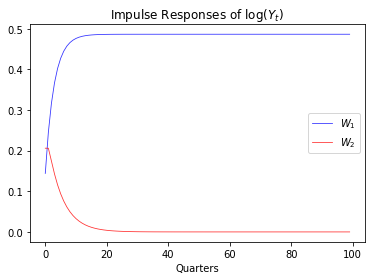

In [6]:
states_IRF = []
controls_IRF = []
T = 100 # time horizon for IRF computation
for shock_index in [0,1]: # we have two shocks for this model
    states, controls = modelSol.IRF(T, shock_index)
    states_IRF.append(states)
    controls_IRF.append(controls)

plt.plot(np.cumsum(states_IRF[0][:,2])*100, color='b', lw=0.8, alpha=0.8, label = "$W_1$")
plt.plot(np.cumsum(states_IRF[1][:,2])*100, color='r', lw=0.8, alpha=0.8, label = "$W_2$")
plt.legend()
plt.xlabel("Quarters")
plt.title("Impulse Responses of $\log(Y_t)$")
# plt.savefig("IncomeIRF", dpi = 300)
plt.show()

In [7]:
modelSol.X1_tp1['x']

array([[ 0.022513,  0.002828,  0.      ,  0.015984, -0.009595,  0.001512],
       [ 0.020151,  0.002835,  0.      ,  0.01604 , -0.009618,  0.001512],
       [ 0.841974,  0.000457,  0.      , -0.003318, -0.001551,  0.001536],
       [ 0.064614,  0.002706,  0.      ,  0.014992, -0.009182,  0.001514],
       [-0.09187 ,  0.000266,  0.      ,  0.002164, -0.000902, -0.000003],
       [ 0.562755, -0.001628,  0.      , -0.013255,  0.005524,  0.000016],
       [-0.065087,  0.003925,  0.      , -0.015137,  0.009242, -0.001513],
       [ 0.904058,  0.000278,  0.      , -0.00478 , -0.000942,  0.001537],
       [-0.071416,  1.000207,  0.      , -0.021785,  0.009078,  0.000026],
       [ 0.      ,  0.      ,  0.      ,  0.00704 ,  0.      , -0.00154 ],
       [ 0.      ,  0.      ,  0.      ,  0.704   ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      , -0.154   ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  1.      ,  0.      ]])

In [8]:
modelSol.X1_tp1['w']

array([[ 0.00327 , -0.002023],
       [ 0.003283, -0.002023],
       [-0.001108, -0.002057],
       [ 0.003045, -0.002025],
       [ 0.000491,  0.000004],
       [-0.003007, -0.000024],
       [-0.003045,  0.002025],
       [-0.00144 , -0.00206 ],
       [ 0.      ,  0.      ],
       [ 0.00144 ,  0.00206 ],
       [ 0.144   ,  0.      ],
       [ 0.      ,  0.206   ],
       [ 0.      ,  0.      ]])